# CNN Quick Drew Example
- This notebook show you to load dataset, train mobilenet, test the model and convert to tflite for deployment on nuvoTon target board.
- Please follow the step by step and you could change the parameters for exploring the possibility.  

In [1]:
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import ast
import re
import pathlib
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D 
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
start = dt.datetime.now()

In [2]:
DP_DIR = './dataset/train_simplified_all_shuffle' # The shuffled dataset
INPUT_DIR = './dataset/train_simplified'          # The original dataset with label in file's name
BASE_IMG_SIZE = 256                               # The original image's pixel size.
NUM_CSVS = 100                                    # The total shuffled fcsv files.
NUM_CATS = 340                                    # The classes number

WORK_DIR = './workspace/340_all_CNN_NEW'     # The user defined name of work dir
MODEL_NAME = 'CNN_340_all'                        # The output model's name

STEPS_P_EPOCH = 700                               # For trining, how many steps per epoch 
INPUT_IMG_SIZE = 32                               # The size of training input image
BATCHSIZE = 512                                   # For train data generator's batchsize => train data number every 1 epoch = STEPS_P_EPOCH * BATCHSIZE

EPOCHS = 50                                      # How many EPOCHS for 1 training.

MODEL_TYPE = 'cnn'                                # 'cnn', 'ds-cnn'

np.random.seed(seed=1987)
#tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(INPUT_DIR)
    return sorted([f2cat(f) for f in files], key=str.lower)

def create_dirs(proj_path, model_name): 
    if not os.path.exists(proj_path):
        os.makedirs(proj_path)
        os.makedirs(os.path.join(proj_path, model_name))
        os.makedirs(os.path.join(proj_path, 'tflite'))
        os.makedirs(os.path.join(proj_path, 'checkpoint'))
    else:
        print('Work folder exist!')    
    return proj_path

create_dirs(WORK_DIR, MODEL_NAME)    

Work folder exist!


'./workspace/340_all_CNN_NEW'

## 1. Create Image Generator for training and the validation dataset

In [3]:
def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_IMG_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def draw_cv2_noresize(raw_strokes, size=256, lw=1):

    #line width
    # lw = np.round((size / BASE_IMG_SIZE) * 6.0).astype(np.int8)

    # Define a function to add 1 to each element
    def add_one_to_element(element):
        return np.round((element / 255.) * (size - 1)).astype(np.int8)
    
    # Use map to apply the function to each element in the nested list
    result_strokes = list(map(lambda inner_list: list(map(lambda sublist: list(map(add_one_to_element, sublist)), inner_list)), raw_strokes))

    img = np.zeros((size, size), np.uint8)
    for stroke in result_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)

    return img

def image_generator(size, BATCHSIZE, ks, lw=1):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=BATCHSIZE):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size))
                for i, raw_strokes in enumerate(df.drawing.values):
                    #x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
                    x[i] = draw_cv2_noresize(raw_strokes, size=size, lw=lw)
                x = x / 255.
                x = x.reshape((len(df), size, size, 1)).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NUM_CATS)
                yield x, y

def df_to_image_array(df, size, lw=1):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        #x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
        x[i] = draw_cv2_noresize(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x

In [4]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NUM_CSVS - 1)), nrows=4*10**5) # Use the final csvs as validation set
x_valid = df_to_image_array(valid_df, INPUT_IMG_SIZE)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NUM_CATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(400000, 32, 32, 1) (400000, 340)
Validation array memory 1.53 GB


## 2. Start to training

- #### Load train data generator

In [5]:
train_datagen = image_generator(size=INPUT_IMG_SIZE, BATCHSIZE=BATCHSIZE, ks=range(NUM_CSVS - 1))

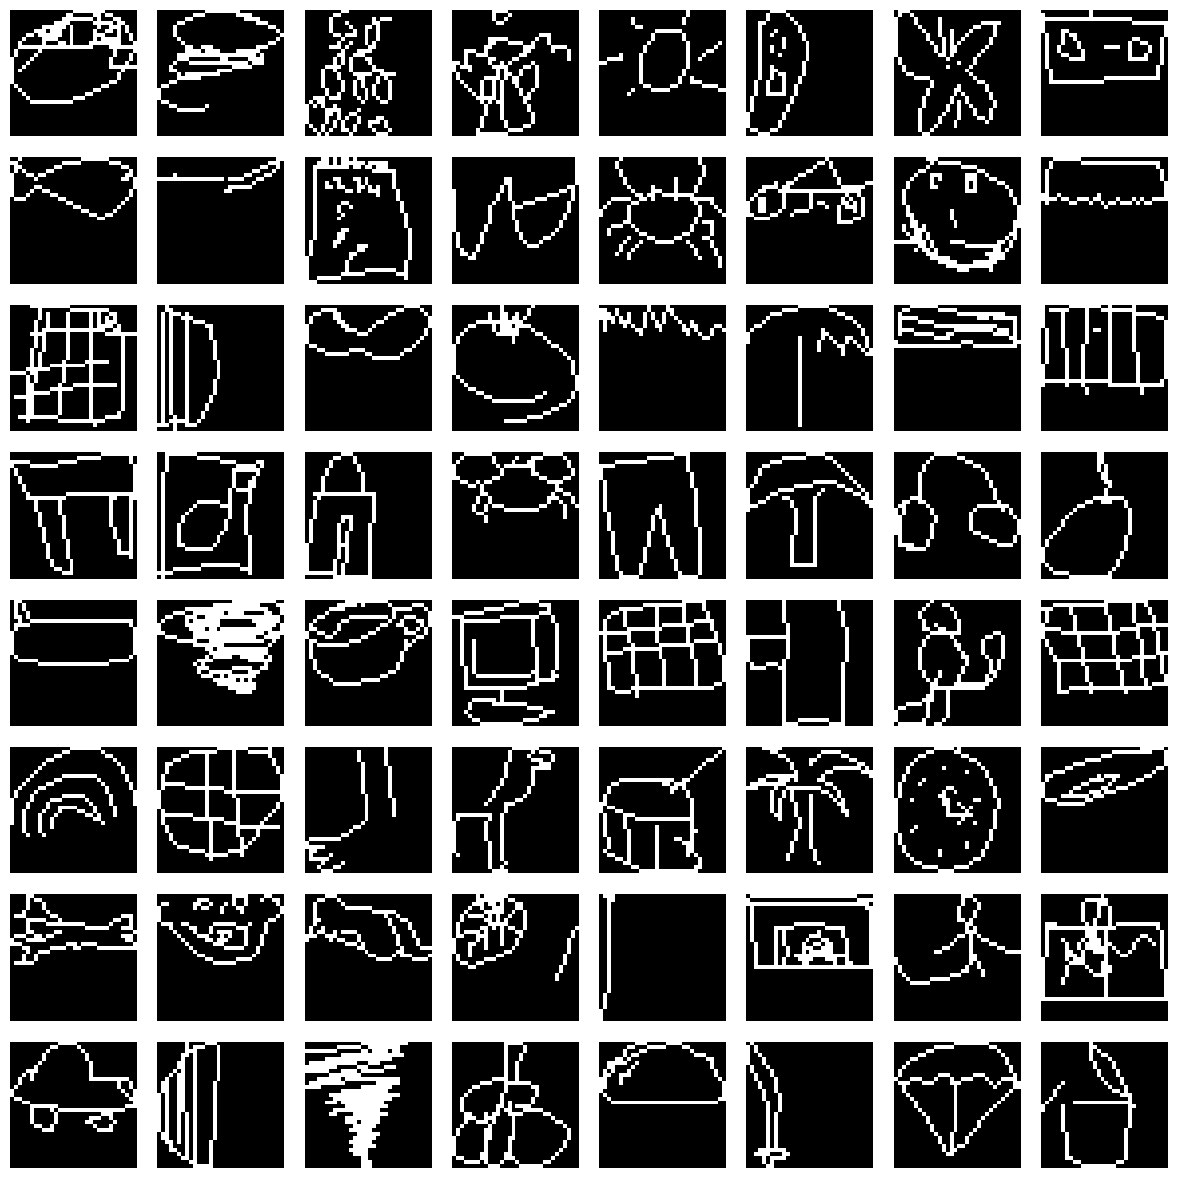

In [6]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x[i, :, :, 0], cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig(os.path.join(WORK_DIR, 'bw.png'), dpi=300)
plt.show();


- #### Create the model & train strategy

In [7]:
def custom_single_cnn(size, conv_layers=(8, 16, 32, 64), conv_dropout=0.2):
    #model = Sequential()
    #model.add(Conv2D(conv_layers[0], kernel_size=(3, 3), padding='same', activation='relu', input_shape=(size, size, 1)))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #if conv_dropout:
    #    model.add(Dropout(conv_dropout))
#
    #for conv_layer_size in conv_layers[1:]:
    #    model.add(Conv2D(conv_layer_size, kernel_size=(3, 3), activation='relu'))
    #    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #    if conv_dropout:
    #        model.add(Dropout(conv_dropout))

    inputs = tf.keras.Input((size, size, 1))
 
    x = Conv2D(conv_layers[0], kernel_size=(3, 3), padding='same', activation='relu', input_shape=(size, size, 1))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    if conv_dropout:
        x = Dropout(conv_dropout)(x)

    for conv_layer_size in conv_layers[1:]:
        x = Conv2D(conv_layer_size, kernel_size=(3, 3), activation='relu')(x)
        #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        if conv_dropout:
            x = Dropout(conv_dropout)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(NUM_CATS, (1, 1), padding="same")(x)
    x = tf.reshape(x,[-1, NUM_CATS])
    outputs = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

def custom_ds_cnn(size, conv_layers=(128, 64), dscnn_layers=(64), conv_dropout=0.2):
    model = Sequential()
    model.add(Conv2D(conv_layers[0], kernel_size=(3, 3), padding='same', activation=None, input_shape=(size, size, 1)))
    model.add(BatchNormalization(epsilon=1e-3, momentum=0.999, name='bn_Conv1_1'))
    model.add(ReLU())
    if conv_dropout:
        model.add(Dropout(conv_dropout))

    for dscnn_layer_size in dscnn_layers[0:]:
        model.add(DepthwiseConv2D(kernel_size=3, strides=1, activation=None, use_bias=False, padding='same'))
        model.add(BatchNormalization(epsilon=1e-3, momentum=0.999))
        model.add(ReLU())

        # Pointwise convolution.
        model.add(Conv2D(filters=dscnn_layer_size, kernel_size=(1, 1)))
        model.add(BatchNormalization(epsilon=1e-3, momentum=0.999))
        #model.add(ReLU())

    for conv_layer_size in conv_layers[1:]:
        model.add(Conv2D(conv_layer_size, kernel_size=(2, 2), padding='same', activation=None))
        model.add(BatchNormalization(epsilon=1e-3, momentum=0.999))
        model.add(ReLU())
        if conv_dropout:
            model.add(Dropout(conv_dropout))

    model.add(GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(NUM_CATS, activation='softmax', use_bias=True, name='Logits'))

    return model

def find_best_ckpt(dir_path, model):
      pattern = re.compile(r"\d.\d+")
      max_number = None
      # Iterate over the files in the directory
      for file in dir_path.iterdir():
          filename = file.name
          match = pattern.search(filename)
          if match:
              number_str = match.group()
              number = float(number_str)
              if max_number is None or number > max_number:
                  max_number = number
      if max_number is None:
          print("There is no best ckpt in this work project.")  
      else:
          print("Find the best ckpt:{}".format(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))
          model.load_weights(str(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))      
      
      return model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [14]:
if MODEL_TYPE.lower() == 'cnn':
    model = custom_single_cnn(size=INPUT_IMG_SIZE,
                          conv_layers=[128, 64],
                          conv_dropout=False)
else:
    model = custom_ds_cnn(size=INPUT_IMG_SIZE,
                          conv_layers=[128, 64, 32],
                          dscnn_layers=[64],
                          conv_dropout=False)
    
# If there is a checkpt, load the previous weights.
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")

# Set the model opt
#model.compile(optimizer=Adam(learning_rate=0.008), loss='categorical_crossentropy',
#              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])  

print(model.metrics)
print(model.summary())

Previous checkpoint folder found; loading saved weights
Find the best ckpt:workspace\340_all_CNN_NEW\checkpoint\0.294_best_val.ckpt
[]
Model: "model_5"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 global_average_pooling2d_5   (None, 1, 1, 64)         0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1, 1, 64)          0         
          

- #### Training section
- This part is training, and it takes 1 to 2 hrs (Nvdia RTX-3090 training from scratch) to get a decent result.
- The actual training time is basing on your hardware, usage size of training dataset and model scale.

In [9]:


callbacks_chpt = tf.keras.callbacks.ModelCheckpoint(
                filepath=(os.path.join(WORK_DIR, 'checkpoint', '{val_categorical_accuracy:.3f}_best_val.ckpt')),
                save_weights_only=True, 
                monitor='val_categorical_accuracy',
                mode = 'max',
                save_best_only=True, 
                save_freq='epoch')

callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=7, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    callbacks_chpt
]

hist = model.fit(
    train_datagen, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/50
700/700 [==============================] - 185s 262ms/step - loss: 3.9846 - categorical_crossentropy: 3.9846 - categorical_accuracy: 0.1807 - top_3_accuracy: 0.3271 - val_loss: 3.6174 - val_categorical_crossentropy: 3.6174 - val_categorical_accuracy: 0.2607 - val_top_3_accuracy: 0.4342 - lr: 0.0024
Epoch 2/50
700/700 [==============================] - 181s 258ms/step - loss: 3.9438 - categorical_crossentropy: 3.9438 - categorical_accuracy: 0.1872 - top_3_accuracy: 0.3356 - val_loss: 3.5692 - val_categorical_crossentropy: 3.5692 - val_categorical_accuracy: 0.2747 - val_top_3_accuracy: 0.4516 - lr: 0.0024
Epoch 3/50
700/700 [==============================] - 287s 411ms/step - loss: 3.9062 - categorical_crossentropy: 3.9062 - categorical_accuracy: 0.1920 - top_3_accuracy: 0.3424 - val_loss: 3.5131 - val_categorical_crossentropy: 3.5131 - val_categorical_accuracy: 0.2795 - val_top_3_accuracy: 0.4590 - lr: 0.0024
Epoch 4/50
700/700 [==============================] - 222s 317ms/st

KeyboardInterrupt: 

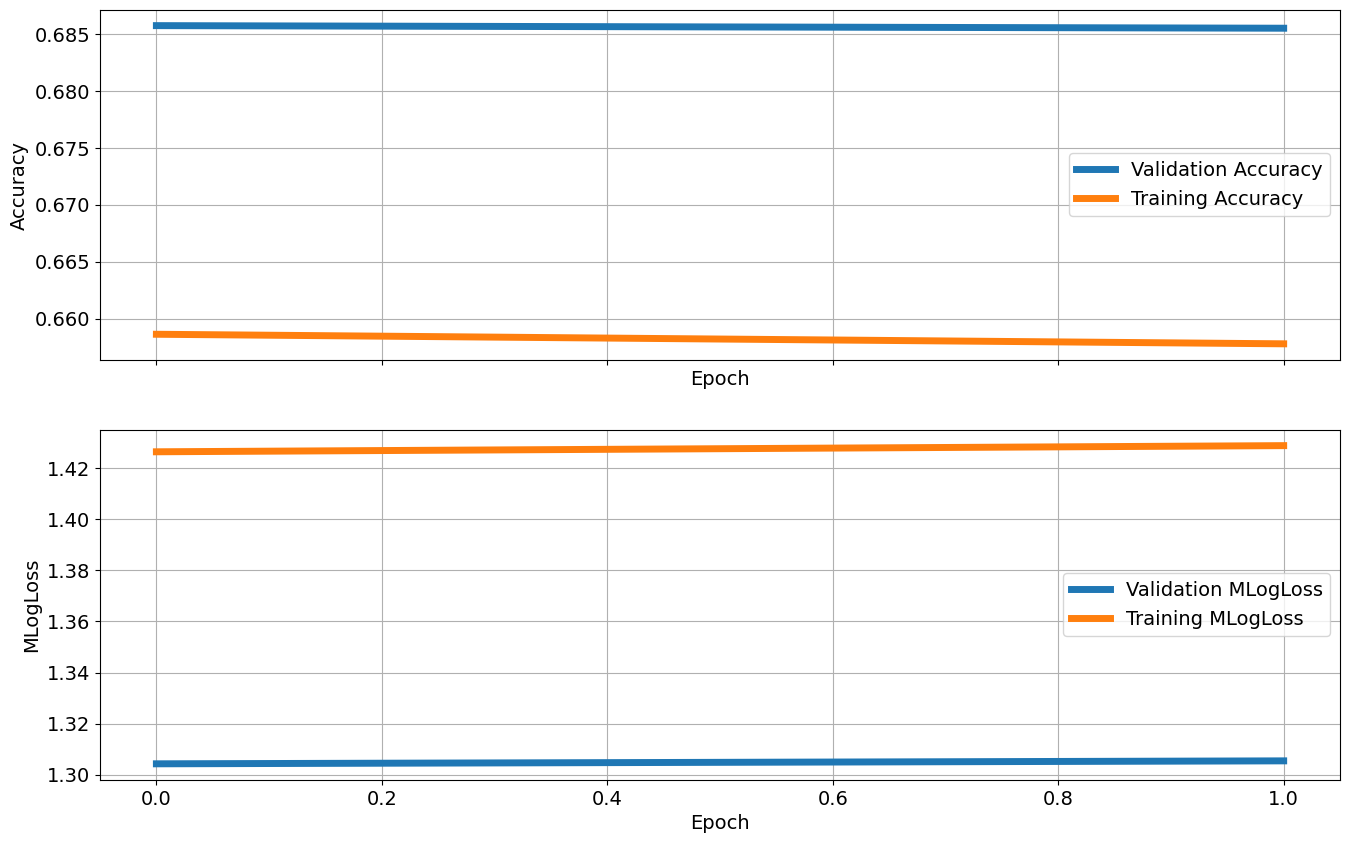

In [14]:
hist_df = pd.DataFrame(hist.history)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(os.path.join(WORK_DIR, 'hist.png'), dpi=300)
plt.show();

## 3. Validation and test the model

In [15]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def preds2catIdx(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top3_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt) | (pred[:,1]==tgt) | (pred[:,2]==tgt) )
    return sc

def top1_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt))
    return sc

In [16]:
# 從checkpoint得到最好的model(val_categorical_accuracy最小)
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")

# Map3: 按照排名給分，第一名hit=>1, 第二名hit=>1/2, 第三名hit=>1/3 以此類推
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catIdx(valid_predictions).values)
top1 = top1_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
top3 = top3_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))
print('Map3: {:.3f}'.format(map3))

Previous checkpoint folder found; loading saved weights
Find the best ckpt:workspace\340_all_CNN\checkpoint\0.686_best_val.ckpt
3125/3125 [==============================] - 5s 1ms/step
Top1 Accuracy: 0.686
Top3 Accuracy: 0.847
Map3: 0.757


## 4. Save the model

In [17]:
model.save(os.path.join(WORK_DIR, MODEL_NAME))
#tf.keras.models.save_model(model, os.path.join(WORK_DIR, MODEL_NAME))

INFO:tensorflow:Assets written to: ./workspace/340_all_CNN\CNN_340_all\assets


INFO:tensorflow:Assets written to: ./workspace/340_all_CNN\CNN_340_all\assets


## 5. Convert to tflite
- Include quantization and offer normal, dynamic quantization, float16 quantization and int8 quantization tflite.

In [18]:
def convert2tflite(custom_model_path, output_tflite_location, rep_dataset, rep_batch):
      
      def representative_dataset():
        
        for img in rep_dataset[0:rep_batch]:
            
            image = tf.expand_dims(img, axis=0)
            #image = tf.dtypes.cast(image, tf.float32) 
            yield [image]
      
      # load the keras model and the custom op.
      custom_model = keras.models.load_model(os.path.join(WORK_DIR, MODEL_NAME), custom_objects={'top_3_accuracy':top_3_accuracy})

      # normal tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # dynamic tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_dyquant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))
      
      # int8 Full tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
      converter.representative_dataset = representative_dataset
      converter.inference_input_type = tf.int8  # or tf.uint8
      converter.inference_output_type = tf.int8  # or tf.uint8
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_int8quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # f16 tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]
      #converter.representative_dataset = representative_dataset
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_f16quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))

In [19]:
convert2tflite(os.path.join(WORK_DIR, MODEL_NAME), os.path.join(WORK_DIR, 'tflite'), x_valid, 256)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp2ciulhts\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp2ciulhts\assets


The tflite output location: ./workspace/340_all_CNN\tflite\CNN_340_all.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpg8v_898f\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpg8v_898f\assets


The tflite output location: ./workspace/340_all_CNN\tflite\CNN_340_all_dyquant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpd8q0sthh\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpd8q0sthh\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/340_all_CNN\tflite\CNN_340_all_int8quant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp15iv30sa\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp15iv30sa\assets


The tflite output location: ./workspace/340_all_CNN\tflite\CNN_340_all_f16quant.tflite


- #### Test the tflite to make sure the accuracy. 

In [20]:
from tqdm import tqdm
def tflite_inference(rep_dataset, rep_dataset_y, tflite_path, batch_N):
      """Call forwards pass of TFLite file and returns the result.
  
      Args:
          input_data: Input data to use on forward pass.
          tflite_path: Path to TFLite file to run.
  
      Returns:
          Output from inference.
      """

      interpreter = tf.lite.Interpreter(model_path=tflite_path)
      
  
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
  
      input_dtype = input_details[0]["dtype"]
      output_dtype = output_details[0]["dtype"]

      input_shape = input_details[0]['shape']
      output_shape = output_details[0]['shape']
      interpreter.resize_tensor_input(input_details[0]['index'], [batch_N, input_shape[1], input_shape[2], input_shape[3]])
      interpreter.resize_tensor_input(output_details[0]['index'], [batch_N, output_shape[1]])

      interpreter.allocate_tensors()
  
      # Check if the input/output type is quantized,
      # set scale and zero-point accordingly
      if input_dtype == np.int8:
          input_scale, input_zero_point = input_details[0]["quantization"]

          rep_dataset = np.round(rep_dataset/input_scale + input_zero_point)

      else:
          #input_scale, input_zero_point = 1, 0
          input_scale, input_zero_point = input_details[0]["quantization"]
  
      if input_dtype == np.int8:
          output_scale, output_zero_point = output_details[0]["quantization"]
      else:
          output_scale, output_zero_point = 1, 0
      
      # skip the final set < batch_N, bcs the input/output tensor are fix. 
      loop_num = (int)(np.floor(len(rep_dataset)/batch_N))  
      
      acy_all  = 0
      acy_top3 = 0
      for i in tqdm(range(loop_num)):
          #if i == (loop_num - 1):
          #    input_batch = rep_dataset[i*batch_N:-1]
          #else:
          input_batch = rep_dataset[i*batch_N:(i+1)*batch_N]

          interpreter.set_tensor(input_details[0]['index'], tf.cast(input_batch, input_dtype))
          interpreter.invoke()
          output_data = interpreter.get_tensor(output_details[0]['index'])
          output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)
          #print(preds2catIdx(output_data).shape)
          acy_all += top1_acc(valid_df[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          acy_top3 += top3_acc(rep_dataset_y[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          #print('Top3 Accuracy: {:.3f}'.format(top3))

      return   acy_all/loop_num, acy_top3/loop_num

In [21]:
top1, top3 = tflite_inference(x_valid[0:5000], valid_df[['y']][0:5000], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 128) 

100%|██████████| 19/19 [05:10<00:00, 16.32s/it]


In [22]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.683
Top3 Accuracy: 0.848


- #### Load test data and test the Keras & TFlite model. 

In [ ]:
# Use the final csvs as validation set, bcs the validation set is 0~2*10**5, we skip the first 2*10**5
test_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NUM_CSVS - 1)), skiprows=lambda x: x in range(1,(2*10**5+1)), nrows=1*10**5)
x_test = df_to_image_array(test_df, INPUT_IMG_SIZE)
y_test = keras.utils.to_categorical(test_df.y, num_classes=NUM_CATS)
print(x_test.shape, y_test.shape)
print('test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

In [ ]:
# Map3: 按照排名給分，第一名hit=>1, 第二名hit=>1/2, 第三名hit=>1/3 以此類推
valid_predictions = model.predict(x_test, batch_size=128, verbose=1)
map3 = mapk(test_df[['y']].values, preds2catIdx(valid_predictions).values)
top1 = top1_acc(test_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
top3 = top3_acc(test_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
print('Test Keras model:')
print('Test Top1 Accuracy: {:.3f}'.format(top1))
print('Test Top3 Accuracy: {:.3f}'.format(top3))
print('Map3: {:.3f}'.format(map3))

In [ ]:
top1, top3 = tflite_inference(x_test[0:10000], test_df[['y']][0:10000], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 128)

In [ ]:
print('Test TFLite model:')
print('Test Top1 Accuracy: {:.3f}'.format(top1))
print('Test Top3 Accuracy: {:.3f}'.format(top3))   